## Import Packages

In [1]:
from dask.distributed import Client
from dask.diagnostics import ProgressBar
import dask
import dask.delayed
import numpy as np
import xarray as xr
import geopandas as gpd
import hvplot.xarray
from matplotlib import pyplot as plt
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
%matplotlib inline
import sklearn.linear_model
import skimage.morphology
import skimage.segmentation
#import richdem as rd
import scipy.ndimage
import dask
import math
import scipy.sparse
import shapefile
import shapely

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # This is added back by InteractiveShellApp.init_path()


In [2]:
import os
import dask
from dask_gateway import Gateway
from dask.distributed import Client
import dask_gateway
import dask.array as da

## Open Cluster

## Scale cluster and connect a client
"cluster" will show the interactive scaling controls and the dashboard link, which can be pasted into the Dask labextension.

In [18]:
# connect a client
# the distributed client is used for running parallel tasks with Dask
client = Client(cluster)

In [19]:
client

Client Scheduler: gateway://traefik-ooi-prod-dask-gateway.ooi-prod:80/ooi-prod.e6a41b43f9df42bf86547690957d4aa6 Dashboard: /services/dask-gateway/clusters/ooi-prod.e6a41b43f9df42bf86547690957d4aa6/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [20]:
cd REMAWaterRouting/

[Errno 2] No such file or directory: 'REMAWaterRouting/'
/home/jovyan/REMAWaterRouting


pip install dask_image

import dask_image.ndfilters


# Part 1: REMA DEM drainage basins

## Import REMA tile from google bucket

In [21]:
#read in the shapefiles of ice shelf grounding lines
IS = gpd.read_file('IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp') 

In [22]:
#select an ice shelf, the Amery Ice Shelf in east Antarctica
Amery = IS[IS.NAME=='Amery']

In [23]:
#read in the REMA tile index
REMA_index = gpd.read_file('REMA_Tile_Index/REMA_Tile_Index_Rel1_1.shp')

<AxesSubplot:>

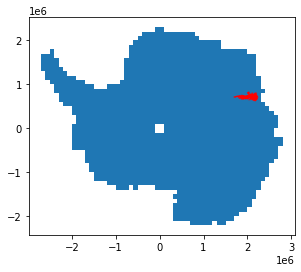

In [24]:
fig,axis = plt.subplots()
REMA_index.plot(ax=axis)
Amery.geometry.plot(ax=axis,color='r')

In [27]:
#bounding box of ice shelf
[minx,miny,maxx,maxy]= Amery.bounds.values.tolist()[0]

bbox = shapely.geometry.asPolygon([[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy],[minx,miny]])

IS_intersection = np.argwhere(REMA_index.overlaps(bbox).tolist())

IS_tiles = REMA_index.tile[IS_intersection.flatten()]

row=np.zeros((len(IS_tiles),1))
col=np.zeros((len(IS_tiles),1))
for i in np.arange(0,len(IS_tiles)):
    [row[i],col[i]] = str.split(IS_tiles.to_list()[i],sep='_')


row = np.int_(row)
col = np.int_(col)

#Load the REMA tiles lazily
uri_fmt = 'https://storage.googleapis.com/pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

chunksize = 8 * 512
rows = []
for i in tqdm(range(row.max()-1, row.min()-1, -1)): #this tile range is Amery Ice Shelf
    cols = []
    for j in range(col.min(),col.max()):
        uri = uri_fmt.format(i_idx=i, j_idx=j)
        try:
            dset = xr.open_rasterio(uri, chunks=chunksize)
            dset_masked = dset.where(dset > 0.0)
            cols.append(dset_masked)
            #print(uri)
        except RasterioIOError:
            pass
    rows.append(cols)

In [28]:
dsets_rows = [xr.concat(row, 'x') for row in rows]
ds = xr.concat(dsets_rows, 'y', )
ds.data

,Array,Chunk
Bytes,7.50 GB,67.11 MB
Shape,"(1, 25000, 75000)","(1, 4096, 4096)"
Count,972 Tasks,192 Chunks
Type,float32,numpy.ndarray


In [29]:
ds_array = ds.squeeze()
ds_array.data

dask.array<getitem, shape=(25000, 75000), dtype=float32, chunksize=(4096, 4096), chunktype=numpy.ndarray>

### The following is a number of functions translated from Matlab's TopoToolbox to calculate drainage catchements from a DEM:

In [30]:
def flag_nans(dem):
    log_nans = np.isnan(dem);
         # handle NaNs

    if np.any(log_nans):
        flag_nans = 1;
    else:
        flag_nans = 0;
    return flag_nans

In [31]:
def identifyflats(dem):
    flats=np.zeros(dem.size)
    
        # handle NaNs
    #log_nans = np.isnan(dem);

    if flag_nans==True:
        #flag_nans = 1;
        dem = dask.array.nan_to_num(dem, nan=-np.inf) 
    else:
       # flag_nans = 0;
        dem = dem


    nhood = np.ones((3,3))
    # identify flats
    # flats: logical matrix with true where cells don't have lower neighbors

    if len(dem)>1:
        flats = skimage.morphology.erosion(image=dem,selem=nhood) == dem;

        #remove flats at the border
        flats[0:-1,[1, -1]]  = 0;
        flats[[0 -1],0:-1]  = 0;

        flats = skimage.segmentation.clear_border(flats, buffer_size=2)

       # if flag_nans==1:
        #    # remove flat pixels bordering to nans
         #   flats[skimage.morphology.dilation(image=log_nans,selem = nhood)] = 0
    return flats

In [32]:
def identifysills(dem,flats):
    # identify sills
    sills=np.zeros(dem.size)
    
    
    log_nans = np.isnan(dem);

    # find sills and set marker
    if len(dem)>1:
        Imr = -np.inf * np.ones(flats.shape);
        Imr[flats.astype(int)] = 0;
        maskeddem = np.multiply(dem,flats)
        Imr = Imr + maskeddem;
        Imr = (skimage.morphology.dilation(image=Imr,selem=nhood) == dem) & np.logical_not(flats);

        if flag_nans==True:
               Imr[log_nans] = 0;

        sills = Imr
    return sills

In [33]:
def identifyinteriorbasins(dem):
    log_nans = np.isnan(dem);

    # identify interior basins
    interiorbasins=np.zeros(dem.size)

    if len(dem)>1:
        interiorbasins = skimage.morphology.local_minima(dem);

        if flag_nans==1:
            interiorbasins = skimage.morphology.local_minima(dem);
            interiorbasins = np.bitwise_or(interiorbasins,log_nans);
            if interiorbasins.shape[0]>0:
                interiorbasins = skimage.segmentation.clear_border(interiorbasins, buffer_size=0);
                interiorbasins= np.multiply(interiorbasins,log_nans)
    else:
        if interiorbasins.shape[0]>0:
            interiorbasins = skimage.segmentation.clear_border(interiorbasins);

    return interiorbasins

In [34]:
import heapq
from imageio import imread


DIR_STRINGS = ["left", "down", "right", "up"]
DIRS = ((-1, 0), (0, -1), (1, 0), (0, 1))

def map_image_to_costs(D, PreSillPixel):
    """
    Read image data and convert it to a marginal cost function,
    a 2D array containing costs for moving through each pixel.
    This cost field forms the input for the weighted distance transform
    zero costs denote exits, infinite costs denote fully impenetrable obstacles.
    In this example, we follow Mercurial standards: obstacles are in black, exits in green,
    accessible space is in white, less accessible space has less white.
    Adapt to your own needs.
    :param image: String of image file or open file descriptor of image
    :return: 2D array representing the cost field
    """
    
    G = (D-np.min(D))/(np.max(D)-np.min(D))**-1
    if len(PreSillPixel)>0:
        for pair in PreSillPixel:
            PSPx = int(pair[0])
            PSPy = int(pair[1])

        #R = abs(D)*255/np.max(abs(D))

        G[PSPx,PSPy] = 1
        #B = abs(D)*255/np.max(abs(D)
    
    data = G*256
    # Exits are present in all green enough places ("G >> R and G")
    exits = np.where(data >= 255 )
    # Obstacles are in black (so at least G and B must be zero)
    obstacles = np.where(data < 1)
    # Convert image to greyscale
    grey_scales = data
    # Boolean index array for places without exits and obstacles
    space = np.ones(grey_scales.shape, dtype=np.bool)
    space[obstacles] = False
    space[exits] = False
    # Cost field: Inversely proportional to greyscale values
    cost_field = np.empty(data.shape)
    cost_field[obstacles] = np.inf
    cost_field[exits] = 0
    cost_field[space] = 1. / (grey_scales[space])
    return cost_field

def _wdt_python(cost_field):
    """
    See `get_weighted_distance_transform`
    :param cost_field: 2D array
    :return: Weighted distance transform array with same shape as `cost_field`
    """
    nx, ny = cost_field.shape
    # Cost for moving along horizontal lines
    costs_x = np.ones([nx + 1, ny], order='F') * np.inf
    costs_x[1:-1, :] = (cost_field[1:, :] + cost_field[:-1, :]) / 2
    # Cost for moving along vertical lines
    costs_y = np.ones([nx, ny + 1], order='F') * np.inf
    costs_y[:, 1:-1] = (cost_field[:, 1:] + cost_field[:, :-1]) / 2

    # Initialize locations (known/unknown/exit/obstacle)
    weighted_distance_transform = np.ones_like(cost_field, order='F') * np.inf
    exit_locs = np.where(cost_field == 0)
    obstacle_locs = np.where(cost_field == np.inf)
    weighted_distance_transform[exit_locs] = 0

    # Initialize Cell structures
    all_cells = {(i, j) for i in range(nx) for j in range(ny)}
    known_cells = {cell for cell in zip(exit_locs[0], exit_locs[1])}
    unknown_cells = all_cells - known_cells - {cell for cell in zip(obstacle_locs[0], obstacle_locs[1])}
    new_candidate_cells = set()
    for cell in known_cells:
        new_candidate_cells |= _get_new_candidate_cells(cell, unknown_cells)
    cand_heap = [(np.inf, cell) for cell in new_candidate_cells]
    # Loop until all unknown cells have a distance value
    if len(cand_heap)>0:
        while True:
            # by repeatedly looping over the new candidate cells
            for cell in new_candidate_cells:
                # Compute a distance for each cell based on its neighbour cells
                distance = _propagate_distance(cell, [costs_x, costs_y], weighted_distance_transform)
                # Store this value in the heap (for fast lookup)
                # Don't check whether we have the distance already in the heap; check on outcome
                heapq.heappush(cand_heap, (distance, cell))
            # See if the heap contains a good value and if so, add it to the field. If not, finish.
            # Since we can store multiple distance values for one cell, we might need to pop a couple of times
            while True:
                min_distance, best_cell = heapq.heappop(cand_heap)
                if weighted_distance_transform[best_cell] == np.inf:
                    # Got a good one: no assigned distance in wdt yet
                    break
                elif min_distance == np.inf:  # No more finite values; done
                    return weighted_distance_transform
            # Good value found, add to the wdt and
            weighted_distance_transform[best_cell] = min_distance
            unknown_cells.remove(best_cell)
            new_candidate_cells = _get_new_candidate_cells(best_cell, unknown_cells)
    else:
        weighted_distance_transform = scipy.ndimage.distance_transform_edt(cost_field)+1
        return weighted_distance_transform
    """
    Checks whether an index exists an array
    :param index: 2D index tuple
    :return: true if lower than tuple, false otherwise
    """
    return (0 <= index[0] < nx) and (0 <= index[1] < ny)
def _exists(index, nx, ny):
    """
    Checks whether an index exists an array
    :param index: 2D index tuple
    :return: true if lower than tuple, false otherwise
    """
    return (0 <= index[0] < nx) and (0 <= index[1] < ny)


def _get_new_candidate_cells(cell, unknown_cells):
    """
    Compute the new candidate cells (cells for which we have no definite distance value yet
    For more information on the algorithm: check fast marching method
    :param cell: tuple of index; a new cell that has been added to the distance field
    :param unknown_cells: set of tuples; all cells still unknown
    :return: Set of new candidate cells for which to compute the distance
    """
    new_candidate_cells = set()
    for direction in DIRS:
        nb_cell = (cell[0] + direction[0], cell[1] + direction[1])
        if nb_cell in unknown_cells:
            new_candidate_cells.add(nb_cell)
    return new_candidate_cells


def _propagate_distance(cell, costs, wdt_field):
    """
    Compute the weighted distance in a cell using costs and distances in other cells
    :param cell: tuple, index of a candidate cell
    :param costs: list of cost arrays in X and Y direction
    :param wdt_field: the weighted distance transform field up until now
    :return: a approximate distance based on the neighbour cells
    """
    nx, ny = wdt_field.shape
    # Find the minimal directions along a grid cell.
    # Assume left and below are best, then overwrite with right and up if they are better
    adjacent_distances = np.ones(4) * np.inf
    pots_from_axis = [0, 0]  # [x direction, y direction]
    costs_from_axis = [np.inf, np.inf]  #
    for i, dir_s in enumerate(DIR_STRINGS):
        # Direction for which we check the cost
        normal = DIRS[i]
        nb_cell = (cell[0] + normal[0], cell[1] + normal[1])
        if not _exists(nb_cell, nx, ny):
            continue
        pot = wdt_field[nb_cell]
        # distance in that neighbour field
        if dir_s == 'left':
            face_index = (nb_cell[0] + 1, nb_cell[1])
        elif dir_s == 'down':
            face_index = (nb_cell[0], nb_cell[1] + 1)
        else:
            face_index = nb_cell
        # Left/right is x, up/down is y
        cost = costs[i % 2][face_index]
        # Proposed cost along this direction
        adjacent_distances[i] = pot + cost
        # If it is cheaper to go from the opposite direction
        if adjacent_distances[i] < adjacent_distances[(i + 2) % 4]:
            pots_from_axis[i % 2] = pot
            costs_from_axis[i % 2] = cost
        hor_pot, ver_pot = pots_from_axis
        hor_cost, ver_cost = costs_from_axis
        # Coefficients of quadratic equation (upwind discretization)
    a = 1. / hor_cost ** 2 + 1. / ver_cost ** 2
    b = -2 * (hor_pot / hor_cost ** 2 + ver_pot / ver_cost ** 2)
    c = (hor_pot / hor_cost) ** 2 + (ver_pot / ver_cost) ** 2 - 1

    D = b ** 2 - 4 * a * c
    # Largest root represents upwind approximation
    x_high = (2 * c) / (-b - math.sqrt(D+0.001)) #edited to prevent divide by zero errors
    return x_high


In [35]:
def drainagebasins(Z,flats,sills,interiorbasins, cellsize):  
    
    #[Iobj,SILLS,IntBasin] = identifyflats(Z);
    Z = Z.data
    Z_ravel = np.ravel(Z)
    nrc = Z_ravel.shape[0]
    
    Iobj  = flats
    SILLS = sills
    IntBasin = interiorbasins

    # Here we choose the distance transform from outside the lakes to the inside and take the locations as sills where the distance is maximum.
    DD = scipy.ndimage.distance_transform_edt(np.bitwise_not(IntBasin));
    MaxIntIX = [0,0] #added to prevent MaxIntIX does not exist errors
    IntBasin_labels = skimage.measure.label(IntBasin)
    for r in np.arange(1,np.max(IntBasin_labels)):
        PixelIdxList = np.argwhere(IntBasin_labels==r)
        ixm = np.argmax(DD[IntBasin_labels==r]);
        MaxIntIX = PixelIdxList[ixm];

        Iobj[PixelIdxList[0][0],PixelIdxList[0][1]] = 0;
        SILLS[PixelIdxList[0][0],PixelIdxList[0][1]] = 1;
    ixm = MaxIntIX;
    Iobj[ixm[0],ixm[1]] = 0;
    SILLS[ixm[0],ixm[1]] = 1;

    # establish the connectivity between sills and flats
    #dem = ZintoDB;
    whereSILLS = np.argwhere(SILLS);
    rows=[]
    cols=[]
    for rowcol in whereSILLS:    
        [row,col] = rowcol
        rows = np.append(rows,row)
        cols = np.append(cols,col)

    IXsill    = [rows,cols];
    rowadd = [-1, -1, 0, 1, 1,  1,  0, -1];
    coladd = [ 0,  1, 1, 1, 0, -1, -1, -1];
    PreSillPixel = [0]
    for r  in np.arange(0,8):
        rowp = rows + rowadd[r];
        colp = cols + coladd[r];

        ValidRowColPair1 = np.bitwise_and(rowp>0, colp>0)
        ValidRowColPair2 = np.bitwise_and(rowp<Z.shape[0], colp<Z.shape[1])
        ValidRowColPair  = np.bitwise_and(ValidRowColPair1, ValidRowColPair2) 
        whereValidRowColPair = np.where(ValidRowColPair)

        IXPreSill = [rowp[whereValidRowColPair],colp[whereValidRowColPair]];
        I1 = np.ravel_multi_index([np.int_(rows[whereValidRowColPair]), np.int_(cols[whereValidRowColPair])],Z.shape)
        I2 = np.ravel_multi_index([np.int_(IXPreSill[0]),np.int_(IXPreSill[1])],Z.shape)
        I3 = np.ravel_multi_index([np.int_(IXPreSill[0]),np.int_(IXPreSill[1])], Z.shape)
        PreSillPixelCondition = (np.argwhere(np.bitwise_and((Z_ravel[I1] == Z_ravel[I2]), Iobj.ravel()[I3])))         
        if np.count_nonzero(PreSillPixelCondition)>0:
            for i in np.arange(0,len(PreSillPixelCondition)):
                PreSillPixelAddition = ([IXPreSill[0][PreSillPixelCondition[i]],IXPreSill[1][PreSillPixelCondition[i]]])
                PreSillPixel.append(PreSillPixelAddition)
            else:
                continue
    PreSillPixel.pop(0);
        

    Iobj  = np.bitwise_not(Iobj)    
    D = scipy.ndimage.distance_transform_edt(Iobj)
    masked = np.inf * np.ones(Z.shape,D.dtype); 
    masked[Iobj] = 0;
    D[np.bitwise_not(Iobj)]=np.inf
    D = ((skimage.morphology.reconstruction(seed = D+1,mask=masked,method='erosion'))- D) *cellsize
    D = np.nan_to_num(D)   

    D[Iobj] = 0
    #D = D**-1
    cost_field  = map_image_to_costs(D**-1,PreSillPixel)
    D = _wdt_python(cost_field) +1
    D[Iobj] = -np.inf
    
    #del PreSillPixel
    V = np.reshape(D.data,[1,D.shape[0]*D.shape[1]])
    if np.any(np.isnan(np.diff(D.ravel()))):
        IXSortedFlats = np.arange(0,len(Z_ravel))
        IXSortedFlats = IXSortedFlats[::-1]
    else:
        IXSortedFlats = np.argsort(D.ravel());
        IXSortedFlats = IXSortedFlats[::-1]
    #del D

    ndx = np.arange(np.uint32(0),np.uint32(nrc));
    ndx = ndx[IXSortedFlats];
    
    ndx = np.arange(np.uint32(0),np.uint32(nrc));
    ndx = ndx[IXSortedFlats];
    del IXSortedFlats

    ix = np.argsort(Z_ravel[ndx]);
    ix = ix[::-1]
    ix = ndx[ix]
    del ndx

     # a fast solution that has quite much memory overhead...
    pp = np.zeros(Z_ravel.shape,dtype=np.int32);
    IX = np.arange(np.int32(0),np.int32(Z_ravel.shape));
    pp[ix] = IX;
    pp = pp.reshape(Z.shape)
    
    # cardinal neighbors
    IXC1 = skimage.morphology.dilation(pp, skimage.morphology.selem.diamond(1))
    IXC1 = IXC1.ravel()
    xxx1 = IXC1;
    IX   = IXC1[ix];
    IXC1 = ix[IX];
    
    G1   = (Z_ravel[ix]-Z_ravel[IXC1])/(cellsize);
    I4 = (np.argwhere(ix == IXC1)).ravel()

    I4 = list(I4)
    I4_test = np.zeros(G1.shape)
    I4_test[I4] = -np.inf
    G1 = G1 + I4_test;
    #G1[ix == IXC1] = -np.inf;

     # diagonal neighbors
    kernel = np.array([[1,0,1],[0,1,0],[1,0,1]])
    IXC2 = skimage.morphology.dilation(pp,kernel);
    IXC2 = IXC2.ravel()
    xxx2 = IXC2;
    IX   = IXC2[ix];
    IXC2 = ix[IX];
    G2   = (Z_ravel[ix]-Z_ravel[IXC2])/np.linalg.norm([cellsize,cellsize]);


    # choose the steeper one
    #I  = np.bitwise_and(G1<=G2, xxx2[ix]>xxx1[ix]);
    I  = dask.array.bitwise_and(dask.array.less_equal(G1,G2),xxx2[ix]>xxx1[ix])
    ixc = IXC1;
    ixc[I] = IXC2[I];

    I = ixc == ix;
    ix = ix[np.bitwise_not(I)];
    ixc = ixc[np.bitwise_not(I)];

    # remove nans
    I = np.isnan(Z_ravel);
    ixc = ixc[~I[ix]];
    ix = ix[~I[ix]];
    
    ix = np.int_(ix[~np.isnan(ix)])
    ixc = np.int_(ixc[~np.isnan(ixc)])
    
    DBcounter = 0;
    D = np.zeros(Z_ravel.shape[0],dtype=np.int32);
    outlets=np.zeros((len(ix),1))
    for r in np.arange(len(ix)-1,1,-1):
        if D[ixc[r]] == 0:
            DBcounter = DBcounter+1;
            D[ixc[r]] = DBcounter;
            outlets[DBcounter] = ixc[r];

        D[ix[r]] = D[ixc[r]];

    D = D.reshape(Z.shape)
    return D

In [36]:
#mask = np.ones(ds_array.shape)
#mask[0,:]=0
#mask[-1,:]=0
#mask[:,0]=0
#mask[:,-1]=0

#masked_array = dask.array.multiply(ds_array,mask)

coarsed_masked_array = ds_array.coarsen(x=50,y=50).mean()

coarsed_masked_array.shape

(500, 1500)

In [37]:
coarsed_masked_array = coarsed_masked_array.chunk((250,250))

sample  = coarsed_masked_array#[250:500,250:500]

sample  

<xarray.DataArray (y: 500, x: 1500)>
dask.array<rechunk-merge, shape=(500, 1500), dtype=float32, chunksize=(250, 250), chunktype=numpy.ndarray>
Coordinates:
    band     int64 1
  * y        (y) float64 7.998e+05 7.994e+05 7.99e+05 ... 6.006e+05 6.002e+05
  * x        (x) float64 1.6e+06 1.601e+06 1.601e+06 ... 2.199e+06 2.2e+06

In [38]:
sample = sample.persist()

In [39]:
flag_nans_ = dask.array.any(dask.array.isnan(sample.data))

In [ ]:
flag_nans = flag_nans_.compute()

In [301]:
nhood = np.ones((3,3))
identified_flats = sample.data.map_blocks(identifyflats, dtype=float)


In [302]:
identified_flats

dask.array<identifyflats, shape=(250, 750), dtype=float64, chunksize=(250, 250), chunktype=numpy.ndarray>

In [303]:
flats = identified_flats.persist()

In [304]:
flats

dask.array<identifyflats, shape=(250, 750), dtype=float64, chunksize=(250, 250), chunktype=numpy.ndarray>

In [305]:
identified_sills = dask.array.map_blocks(lambda dem,flats: identifysills(dem,flats), sample.data, identified_flats, dtype=float)#identifysills(sample_and_flats) #still would like to do this chunkwise

In [306]:
sills = identified_sills.persist()

In [307]:
sills

dask.array<lambda, shape=(250, 750), dtype=float64, chunksize=(250, 250), chunktype=numpy.ndarray>

In [308]:
identified_interbasins = sample.data.map_overlap(lambda dem: identifyinteriorbasins(dem), depth=1, dtype=float)

In [309]:
interiorbasins = identified_interbasins.persist()

In [310]:
interiorbasins

dask.array<_trim, shape=(250, 750), dtype=float64, chunksize=(250, 250), chunktype=numpy.ndarray>

In [313]:
cellsize = 100*100

In [314]:
FlowObj_dask = lambda dem,flats,sills,interiorbasins: drainagebasins(dem,flats,sills,interiorbasins,cellsize)

In [315]:
dem = sample.data

flats  = flats
FlowObj_values = dask.array.map_blocks(FlowObj_dask,dem,flats,sills,interiorbasins,dtype=float)

In [316]:
DB = FlowObj_values.compute()

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in subtract
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in reciprocal
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in subtract
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/lib/function_base.py:1280: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


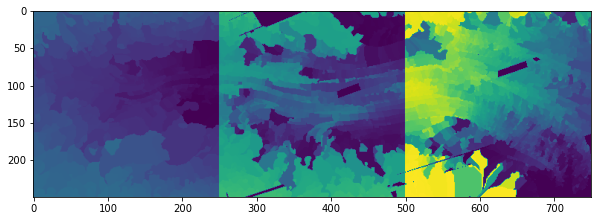

In [317]:
plt.figure(figsize=(10,20))
plt.imshow(DB)
#plt.colorbar()

In [318]:
def cleandrainagebasins(D,chunksize):   
    D_labelled = skimage.morphology.label(D)

    D_labelled_new = D

    #merge down
    for i in np.arange(D.shape[0]%chunksize,D.shape[0],chunksize):
        topside = D[i-1,:]
        topside_values = np.argwhere(np.diff(topside)!=0)
        for ii in np.arange(0,len(topside_values)):
            col_to_merge = topside_values[ii]
            basin_to_merge = D_labelled[i,col_to_merge]
            mask_right = np.argwhere(D_labelled == basin_to_merge)
            [mask_x,mask_y] = np.array(mask_right).T
            D_labelled_new[mask_x,mask_y] = D[i-1,topside_values[ii]]

    #Merge left
    for i in np.arange(D.shape[1]%chunksize,D.shape[1],chunksize):
        leftside = D_labelled[:,i-1]
        leftside_values = np.argwhere(np.diff(leftside)!=0)
        for ii in np.arange(0,len(leftside_values)):
            row_to_merge = leftside_values[ii]
            basin_to_merge = D_labelled[row_to_merge,i]
            D_labelled_new[D_labelled == basin_to_merge] = D[leftside_values[ii],i-1]

    xarray_D = xr.DataArray(data = D_labelled_new, coords = sample.coords,dims = sample.dims, attrs = sample.attrs)
    return xarray_D

In [319]:
DB = cleandrainagebasins(DB,250)

<AxesSubplot:title={'center':'band = 1'}, xlabel='x', ylabel='y'>

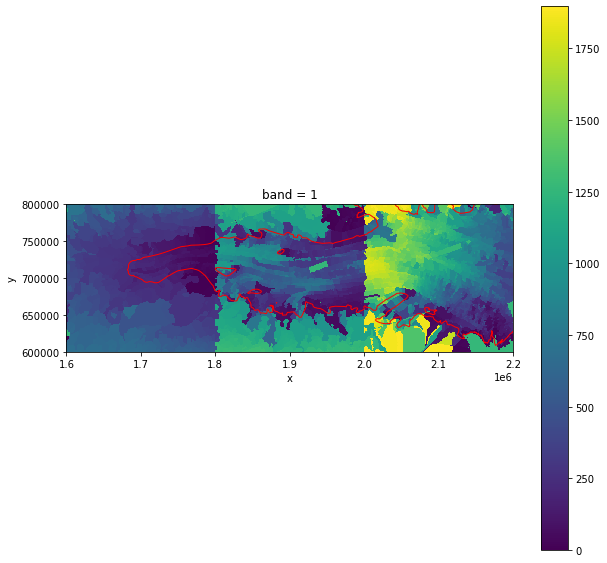

In [321]:
fig, ax = plt.subplots(figsize=(10,10))
DB.plot(ax=ax)
Amery.plot(ax=ax, facecolor='None',edgecolor='r')

# Part 2. Calculate water depths and basin hypsometry (Still in progress)

In [322]:
def Inan(dem):
    Inan = np.isnan(dem)
    return Inan

In [323]:
Inans = dask.array.isnan(sample)

In [324]:
Inans = Inans.compute()

In [325]:
dem_nonans =  sample.fillna(-np.inf)

In [326]:
def filledbasins(dem,Inans):
    marker = np.negative(dem);
    #dem = dem + np.multiply(Inans,-np.inf)
    II = np.zeros(dem.shape);
    II[1:-1,1:-1] = 1;
    mask = np.bitwise_and(np.bool_(II),~Inans)*-np.inf
    marker = marker+mask;
    demfs = -skimage.morphology.reconstruction(marker,-dem, method='dilation')

    return demfs

In [327]:
demfs_task = lambda dem,Inans: filledbasins(dem_nonans,Inans)

In [328]:
demfs = dask.array.map_blocks(demfs_task, dem=dem_nonans, Inans=Inans, dtype=float)

In [329]:
demfs

dask.array<lambda, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [330]:
filled =  demfs.compute()

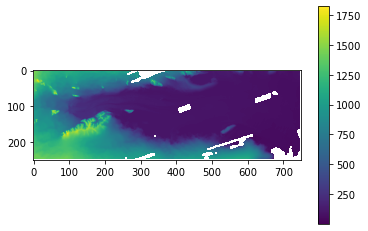

In [331]:
plt.imshow(filled)
plt.colorbar()

In [332]:
demfs

dask.array<lambda, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [333]:
depths = filled-sample

In [334]:
depths

<xarray.DataArray (y: 250, x: 750)>
dask.array<subtract, shape=(250, 750), dtype=float64, chunksize=(250, 250), chunktype=numpy.ndarray>
Coordinates:
    band     int64 1
  * y        (y) float64 7.996e+05 7.988e+05 7.98e+05 ... 6.012e+05 6.004e+05
  * x        (x) float64 1.6e+06 1.601e+06 1.602e+06 ... 2.199e+06 2.2e+06

In [335]:
P_all = depths.compute()

In [336]:
P_all

<xarray.DataArray (y: 250, x: 750)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.        , 0.        , ..., 0.        , 0.        ,
               nan],
       [       nan, 0.        , 0.        , ..., 0.28269958, 0.        ,
               nan],
       ...,
       [       nan, 0.        , 0.        , ...,        nan,        nan,
               nan],
       [       nan, 0.        , 0.        , ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
    band     int64 1
  * y        (y) float64 7.996e+05 7.988e+05 7.98e+05 ... 6.012e+05 6.004e+05
  * x        (x) float64 1.6e+06 1.601e+06 1.602e+06 ... 2.199e+06 2.2e+06

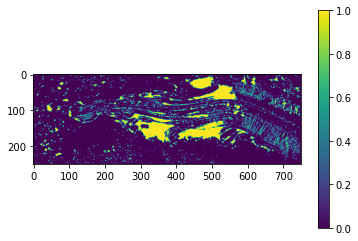

In [337]:
plt.imshow(P_all>0)
plt.colorbar()

In [338]:
import pandas  as pd

In [339]:
cellsize

10000

In [340]:
#Build  data structure  on each drainage Catchments

b_dict = {'CatchmentNumber','CatchmentArea','MaskLogical','MaskI','MaskXY','skip','Volume','maxdepth','hw','h','p'}
b = pd.DataFrame(data={},columns=b_dict)

In [343]:
histcount = np.bincount(DB.data.ravel())
catchment_num = np.max(DB.data.ravel())
valid_catchment= []
for kk in np.arange(0,catchment_num):
    CatchmentNumber = kk;
    Mask = DB.data == kk; 
    CatchmentArea = (np.sum(np.int_(Mask.ravel()))*cellsize); # basin area in m^2
    if CatchmentArea>0:
        valid_catchment = np.append(valid_catchment,kk)
    

In [344]:
valid_catchment

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.894e+03, 1.895e+03,
       1.896e+03])

In [345]:
for catchment in valid_catchment:
    CatchmentNumber = catchment;
    Mask = DB.data == catchment; 
    CatchmentArea = (np.sum(np.int_(Mask.ravel()))*cellsize); # basin area in m^2
    MaskLogical = Mask;
    MaskXY = np.where(Mask);  # mask for the basin
    MaskI= np.ravel_multi_index(MaskXY,dem.shape)
    depths = P_all.data[MaskXY] #Water accomodation space in drainage basin
    if np.count_nonzero(depths>0)<4: #If accomodation space is zero, i.e, no nonzero depths
        skip = 1;
        h = 0;
        maxdepth = 0;
        Volume = 0;
        hw = np.zeros(depths.size)
        continue
    else:
        valid = np.argwhere(depths>=0)
        depths = depths[valid];
        heights = np.max(depths) - depths; #potential water height from bottom
        skip = 0;        
        Volume = (np.sum(depths.ravel())*cellsize);
        heights_sorted = np.sort(list(heights.flatten()));
        while len(np.argwhere(np.diff(heights_sorted)==0))>0: #remove all identical pixels
            I = np.argwhere(np.diff(heights_sorted)==0);
            heights_sorted[I+1] = heights_sorted[I+1] +0.0001; # nudge the similar values up a tiny amount to avoid issues with the interpolation
        hw = heights_sorted;   # heights for hypsometry
        maxdepth = np.max(depths); # not actually the same as max(Heights) the smallest value of depths is not equal to demero
        h = 0;   # initial water depth is demero
        volume = np.zeros((len(heights)-1,1));
        if np.count_nonzero(depths)>5:
            totalVolume = Volume;
            for i in np.arange(0,len(heights)-1):
                volume[i] = (volume[i-1]+ (hw[i+1]-hw[i])*(i*cellsize));

            Y = (np.log(volume/totalVolume));
            X  = list(np.log(hw[0:-1]/maxdepth)),
            X = X[0]
            X.pop(0)
            Y = list(Y.flatten())
            Y.pop(0)
            reg = np.polyfit(list(X),list(Y),1)

            p = reg[0];
        else:
            p = 1;
    data={'CatchmentNumber':CatchmentNumber,
           'CatchmentArea':CatchmentArea,
           'MaskLogical':MaskLogical.ravel(),
           'MaskI':MaskI,
            'MaskXY': MaskXY,
           'skip':skip,
           'Volume':Volume,
           'maxdepth':maxdepth,
           'hw':hw,
           'h':h,
           'p':p
            }
    DrainageBasin = pd.Series(data)
#else:
    #continue
    b = b.append(DrainageBasin, ignore_index=True)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


In [278]:
b

,hw,MaskXY,Volume,maxdepth,CatchmentArea,h,MaskI,CatchmentNumber,p,skip,MaskLogical
0,"[0.0, 4.317905426025391, 8.701934814453125, 8....","([10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 12, ...",47512.621338,76.797306,26048,0,"[2669, 2670, 2919, 2920, 2964, 2965, 3169, 317...",3.0,1.781902,0,"[False, False, False, False, False, False, Fal..."
1,"[0.0, 1.7802848815917969, 3.9401779174804688, ...","([1, 2, 3, 4, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8,...",125330.011963,60.377674,20736,0,"[479, 729, 979, 1229, 1479, 1728, 1729, 1730, ...",5.0,2.307140,0,"[False, False, False, False, False, False, Fal..."
2,"[0.0, 0.49222564697265625, 0.5465621948242188,...","([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,...",6086.873047,7.699997,6656,0,"[480, 481, 482, 483, 484, 485, 730, 731, 732, ...",6.0,2.021664,0,"[False, False, False, False, False, False, Fal..."
3,"[0.0, 0.04981231689453125, 0.07428741455078125...","([24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, ...",1379.416504,2.111717,4608,0,"[6244, 6245, 6493, 6494, 6495, 6496, 6497, 674...",10.0,1.527325,0,"[False, False, False, False, False, False, Fal..."
4,"[0.0, 0.02938079833984375, 0.16638946533203125...","([14, 15, 16, 17, 17, 17, 18, 18, 18, 18, 18, ...",2734.318848,3.296806,2880,0,"[3738, 3988, 4238, 4486, 4487, 4488, 4734, 473...",11.0,1.455455,0,"[False, False, False, False, False, False, Fal..."
...,...,...,...,...,...,...,...,...,...,...,...
936,"[0.0, 1.140869140625, 1.518310546875, 1.782104...","([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",4320.671875,8.076294,19328,0,"[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 304, ...",300.0,2.332126,0,"[False, False, False, False, False, False, Fal..."
937,"[0.0, 0.34130859375, 0.72998046875, 1.43969726...","([221, 222, 222, 222, 223, 223, 223, 223, 223,...",494.484375,2.104126,4992,0,"[55276, 55525, 55526, 55527, 55773, 55774, 557...",302.0,1.461999,0,"[False, False, False, False, False, False, Fal..."
938,"[0.0, 0.551513671875, 0.5958251953125, 0.96582...","([223, 224, 224, 224, 224, 225, 225, 225, 225,...",479.039062,1.762939,18496,0,"[55762, 56011, 56012, 56013, 56014, 56259, 562...",306.0,3.246852,0,"[False, False, False, False, False, False, Fal..."
939,"[0.0, 0.5294189453125, 0.9012451171875, 0.9388...","([240, 240, 240, 241, 241, 241, 241, 241, 241,...",474.140625,2.147705,2752,0,"[60004, 60005, 60006, 60254, 60255, 60256, 602...",311.0,1.925252,0,"[False, False, False, False, False, False, Fal..."


In [346]:
p_map = np.zeros(P_all.shape)

In [347]:
for c in np.arange(0,len(b)):
    p_map[b['MaskXY'][c]] = b['p'][c]*np.ones((1,len(b['MaskI'][c])))

In [352]:
Pmap = DB
Pmap.data = p_map

Text(0.5, 1.0, 'Hypsometry coefficient, p')

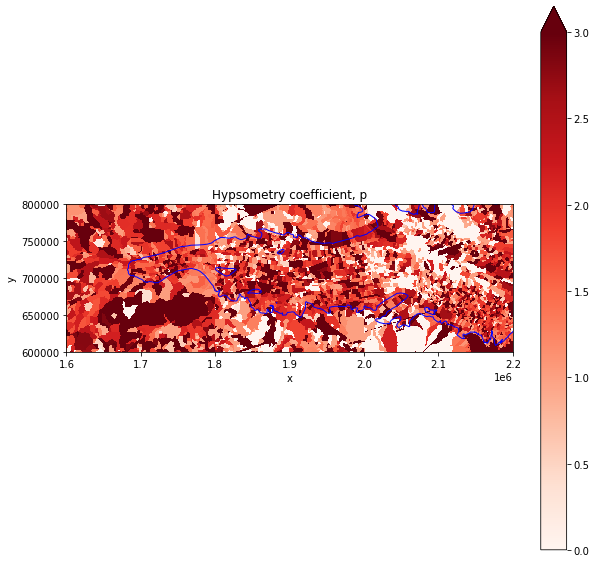

In [367]:
fig, ax = plt.subplots(figsize=(10,10))
pplot = Pmap.plot(ax=ax,vmax=3,cmap='Reds')
Amery.plot(ax=ax, facecolor='None',edgecolor='b')
plt.title('Hypsometry coefficient, p')